In [147]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import os
import pickle
# import dill as pickle

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Conv2D, Dropout, MaxPooling2D
from keras.utils import to_categorical
from keras import metrics
from keras.callbacks import *
from keras import regularizers
import cv2

In [2]:
def get_data_and_labels(df):
    test_data = df.as_matrix(columns=['pixels'])[:, 0]
    test_data = np.array(test_data.tolist())
    # train_data = train_data.reshape(-1, 48, 48)
    test_data = test_data.astype('float32')
    test_data /= 255
    # print(test_data[0])
    test_label = df.as_matrix(columns=['emotion'])
    test_label.shape
    test_label_1hot = to_categorical(test_label)
    test_label_1hot.shape
    return test_data, test_label_1hot, test_label

In [13]:
training = pd.read_pickle('training_set.pkl')
full_test = pd.read_pickle('full_test.pkl')
train_data, train_label_1hot, train_label = get_data_and_labels(training)
test_data, test_label_1hot, test_label = get_data_and_labels(full_test)

In [4]:
from keras.models import load_model, model_from_json
from IPython.display import clear_output

# def save_model(model, name, cnn_history):
#     model_json = model.to_json()
#     with open(name+'.json', 'w') as json_file:
#         json_file.write(model_json)
#     model.save_weights(name+'.h5')
#     pickle.dump(cnn_history, open(name+'.p', 'wb'))
#     print('Saved to: {}'.format(name+'.json/.h5'))


# def load_model(name):
#     with open(name+'.json', 'r') as json_file:
#         model = model_from_json(json_file.read())
#     model.load_weights(name+'.h5')
#     history = pickle.load(open(name+'.p', 'rb'))
#     return model

def save_model(model, name, history):
    model.save(name)
    with open(name+'.p', 'wb') as history_file:
        pickle.dump(history, history_file)
    with open(name+'.json', 'w') as json_file:
        json_file.write(model.to_json())
    return

def load_model_(name):
    model = load_model(name)
    with open(name+'.p', 'rb') as history_file:
        history = pickle.load(history_file)
    return model, history

import sys
def plot_history(history):
    #Plot the Loss Curves
    plt.figure(figsize=[8,3])
    plt.plot(history['loss'],'r',linewidth=3.0)
    plt.plot(history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=11)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
     
    #Plot the Accuracy Curves
    plt.figure(figsize=[8,3])
    plt.plot(history['categorical_accuracy'],'r',linewidth=3.0)
    plt.plot(history['val_categorical_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=11)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
        log_string = '\n'
        for key in logs:
            log_string = log_string + '{{"metric":"{}", "value":{}}}\n'.format(key, logs[key])

        sys.__stdout__.write(str(log_string)+"\n")
        
plot = PlotLearning()

In [5]:
import plotly.offline as plty
from plotly.offline import iplot
import plotly.graph_objs as go
plty.init_notebook_mode(connected=True)
def plotly_history(history, loss_key='loss', acc_key='categorical_accuracy'):
    
    loss_trace = go.Scatter(name='Loss', 
                            y=history[loss_key])
    loss_val_trace = go.Scatter(name='Valdition Loss', 
                                y=history['val_'+loss_key])
    data = [loss_trace, loss_val_trace]
    
    layout = go.Layout(title='Loss Curves', 
                       xaxis=dict(title='Epoch'))
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='loss')
    
    acc_trace = go.Scatter(name='Accuracy', 
                            y=history[acc_key])
    acc_val_trace = go.Scatter(name='Valdition Accuracy', 
                                y=history['val_'+acc_key])
    data = [acc_trace, acc_val_trace]
    
    layout = go.Layout(title='Accuracy Curves', 
                       xaxis=dict(title='Epoch'))
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='accuracy')
    
    
def plot_line(y, x_axis='Epoch', name='curve'):
    trace = go.Scatter(name=name,
                      y=y)
    layout = go.Layout(title=name, 
                       xaxis=dict(title=x_axis))
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=name)

In [7]:
cnn_model, cnn_history = load_model_('./models/cnn_regu_conv_001_drop_dense_e200')

In [8]:
cnn_model.save_weights('./models/cnn_regu_conv_001_drop_dense_e200.h5')

In [9]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        36928     
__________

In [11]:
layer_dict = dict([(layer.name, layer) for layer in cnn_model.layers])

In [12]:
layer_dict

{'conv2d_1': <keras.layers.convolutional.Conv2D at 0x10d2a9588>,
 'conv2d_2': <keras.layers.convolutional.Conv2D at 0x10c00ae80>,
 'conv2d_3': <keras.layers.convolutional.Conv2D at 0x10d2a9278>,
 'conv2d_4': <keras.layers.convolutional.Conv2D at 0x119c53c50>,
 'conv2d_5': <keras.layers.convolutional.Conv2D at 0x119ca06a0>,
 'conv2d_6': <keras.layers.convolutional.Conv2D at 0x119d6ccf8>,
 'dense_1': <keras.layers.core.Dense at 0x119e54ba8>,
 'dense_2': <keras.layers.core.Dense at 0x119eb2828>,
 'dense_3': <keras.layers.core.Dense at 0x119f34f28>,
 'dropout_1': <keras.layers.core.Dropout at 0x119c53a58>,
 'dropout_2': <keras.layers.core.Dropout at 0x119d6cb00>,
 'dropout_3': <keras.layers.core.Dropout at 0x119e549b0>,
 'dropout_4': <keras.layers.core.Dropout at 0x119eb2860>,
 'dropout_5': <keras.layers.core.Dropout at 0x119f34dd8>,
 'dropout_6': <keras.layers.core.Dropout at 0x10c8b98d0>,
 'flatten_1': <keras.layers.core.Flatten at 0x119ddfa90>,
 'max_pooling2d_1': <keras.layers.pooling.

In [ ]:
weights = layer_dict['some_name'].get_weights()

In [31]:
import cv2
path = './images'
def save_image(data, name='img.png', path=path):
    f_path = os.path.join(path, name)
    print(f_path)
    cv2.imwrite(f_path, data)
    
emotions = {0:'Angry', 1:'Disguste', 2:'Fear', 3:'Happy', 
            4:'Sad', 5:'Surprise', 6:'Neutral'}

./images/Happy4195.png


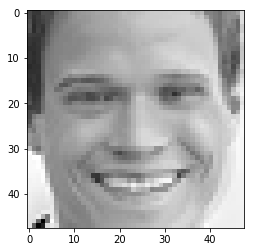

In [283]:
idx = 4195
im = np.reshape(test_data[idx], (48, 48))*255
plt.imshow(im, cmap='gray')
save_image(im, 
           name=emotions[test_label[idx,0]]+str(idx)+'.png')

In [24]:
emotions[test_label[idx,0]]

'Angry'

In [27]:
np.reshape(test_data[idx], (48, 48))

array([[ 1.  ,  1.  ,  1.  , ...,  0.06,  0.  ,  0.63],
       [ 1.  ,  1.  ,  1.  , ...,  0.07,  0.  ,  0.48],
       [ 1.  ,  1.  ,  1.  , ...,  0.1 ,  0.  ,  0.45],
       ..., 
       [ 0.26,  0.34,  0.39, ...,  1.  ,  0.99,  1.  ],
       [ 0.33,  0.36,  0.36, ...,  0.93,  1.  ,  1.  ],
       [ 0.36,  0.35,  0.33, ...,  0.16,  0.51,  0.71]], dtype=float32)

In [36]:
prids = cnn_model.predict_on_batch(test_data) 

In [35]:
prids

array([[ 0.38,  0.08,  0.31,  0.04,  0.06,  0.08,  0.04]], dtype=float32)

In [41]:
with open('./cnn_results_probs.pk' , 'wb') as save_file:
    pickle.dump(prids, save_file)

In [42]:
probs = cnn_model.predict_classes(test_data, batch_size=2048, verbose=1)

7178/7178 [==============================] - 32s 5ms/step


In [43]:
with open('./cnn_results_classes.pk', 'wb') as save:
    pickle.dump(probs, save)

In [44]:
probs[0]

0

### Visulising Weights

In [49]:
layer_dict = dict([(layer.name, layer) for layer in cnn_model.layers])

In [129]:
layer1_weights = layer_dict['conv2d_3'].get_weights()

In [130]:
layer1_weights[0].shape

(3, 3, 32, 64)

In [131]:
len(layer1_weights[1])

64

In [139]:
fil1 = layer1_weights[0][:, :, 0, 0]
fil1

array([[ 0.39,  0.56,  0.56],
       [ 0.56,  0.56,  0.39],
       [ 0.56,  0.56,  0.39]], dtype=float32)

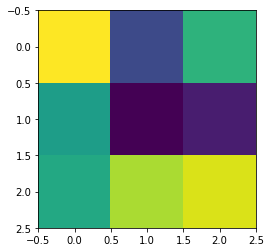

In [66]:
plt.imshow(layer1_weights[0][:, :, :, 0].reshape(3, 3))

In [67]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # convert to RGB array
    x *= 255
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

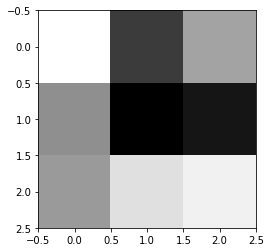

In [70]:
plt.imshow(deprocess_image(fil1), cmap='gray')

In [105]:
ims = 6
lay1_filters = np.zeros(((3+2)*ims-2,(3+2)*ims-2))
lay1_filters.shape

(28, 28)

In [100]:
x = np.linspace(0, 5, 5)
y = np.linspace(0, 5, 5)

In [101]:
layer1_weights[0].shape[-1]

32

In [140]:
for i in range(32):
    c = i % ims
    r = int(i/ims)
    filt = layer1_weights[0][:, :, 2, i].reshape((3,3))
    filt = deprocess_image(filt)
    lay1_filters[(3+2)*r:(3+2)*r+3, (3+2)*c:(3+2)*c+3] = filt

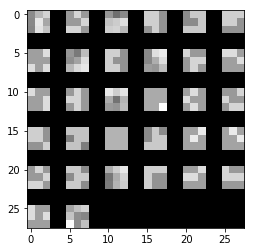

In [141]:
plt.imshow(lay1_filters, cmap='gray')

In [112]:
np.ceil(np.sqrt(29))

6.0

In [161]:
def plot_layer_filters(layer_name='conv2d_6', 
                       layer_dict=layer_dict,
                       num_of_filters=32
                      ):
    layer1_weights = layer_dict[layer_name].get_weights()
    if num_of_filters > layer1_weights[0].shape[-1]:
        Print('Not enough filters')
    filt_size = layer1_weights[0].shape[0]
    ims = int(np.ceil(np.sqrt(num_of_filters)))
    mar = 1
    im_filters = np.zeros(((filt_size+mar)*ims-mar,(filt_size+mar)*ims-mar))
    for i in range(num_of_filters):
        c = i % ims
        r = int(i/ims)
        filt = layer1_weights[0][:, :, 0, i].reshape((filt_size, filt_size))
        filt = deprocess_image(filt)
        im_filters[(3+mar)*r:(3+mar)*r+3, (3+mar)*c:(3+mar)*c+3] = filt
#     im_filters = im_filters.reshape(((filt_size+2)*ims-2,(filt_size+2)*ims-2, 1))
    plt.imshow(im_filters, cmap='gray')
    return im_filters

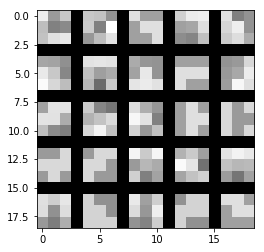

In [162]:
im_filt = plot_layer_filters(layer_name='conv2d_1', num_of_filters=25)

In [235]:
cv2.imwrite('/Users/chandansiyag/Documents/TeX/Advanced Reading/images/layer2_filter_imgs.png', gen_filts[:(48*2+5), :])

True

In [158]:
im_filt = im_filt.reshape((23, 23, 1))

In [260]:
gen_filts = cv2.imread('/Users/chandansiyag/pycharm/face-exp/keras-filter-visualization-master/stitched_filters_1x1.png')

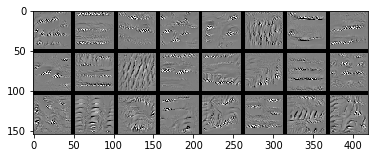

In [261]:
fimgs = gen_filts[:(48*3+5*(3-1)), :]
plt.imshow(fimgs)

In [259]:
cv2.imwrite('/Users/chandansiyag/Documents/TeX/Advanced Reading/images/vs357-layer2_filter_imgs.png', fimgs)

True

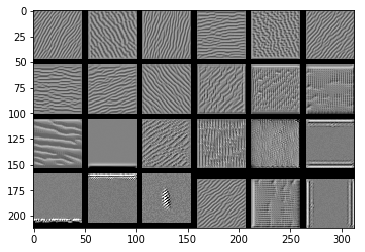

In [212]:
plt.imshow(l2_filts)

In [219]:
l2_filts = np.copy(gen_filts[:(48*3+5), :])

In [220]:
l2_filts.shape

(149, 419, 3)

In [201]:
l2_filts[48*3+20:, 48*3+15:].shape

(48, 154, 3)

In [200]:
np.rot90(gen_filts[:-(48*3+15), -(48*1+0):]).shape

(48, 154, 3)

In [285]:
l2_filts[0]

array([[125, 125, 125],
       [125, 125, 125],
       [118, 118, 118],
       ..., 
       [127, 127, 127],
       [122, 122, 122],
       [128, 128, 128]], dtype=uint8)

In [294]:
img_width, img_height = 48, 48
input_img_data = cv2.imread('/Users/chandansiyag/pycharm/face-exp/images/Happy701.png')
input_img_data = cv2.cvtColor(input_img_data, cv2.COLOR_BGR2GRAY)
input_img_data = input_img_data.reshape((img_width, img_height))
input_img_data = input_img_data.flatten()
input_img_data = input_img_data.reshape((-1, 2304))
input_img_data = np.array(input_img_data / 255, dtype='float32')

In [299]:
img = cv2.imread('keras-filter-visualization-master/stitched_filters_1x1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = img[:48, :48].reshape((48, 48))
img.shape

(48, 48)

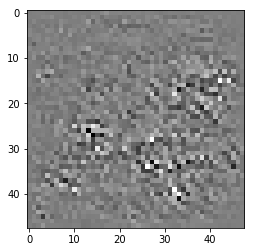

In [300]:
plt.imshow(img, cmap='gray')

In [303]:
in_data = np.array([img.flatten()])
prids = cnn_model.predict_classes(in_data)

In [304]:
[emotions[x] for x in prids]

['Angry']

In [306]:
probs = cnn_model.predict(in_data)

In [307]:
probs

array([[  1.00e+00,   0.00e+00,   4.87e-06,   1.04e-17,   0.00e+00,
          2.44e-16,   0.00e+00]], dtype=float32)